# MVA - Homework 3 - Reinforcement Learning (2022/2023)

**Name:** DE SURREL Thibault

**Email:**    thibault.de-surrel-de-saint-julien@ensta-paris.fr


Note that the assignment is composed by two parts. This one is the practical part.

## Instructions

* The deadline is **January 20 (2023) at 11:59 pm (Paris time).**

* By doing this homework you agree to the late day policy, collaboration and misconduct rules reported on [Piazza](https://piazza.com/class/l4y5ubadwj64mb/post/6).

* **Mysterious or unsupported answers will not receive full credit**. A correct answer, unsupported by calculations, explanation, or algebraic work will receive no credit; an incorrect answer supported by substantially correct calculations and explanations might still receive partial credit.

* Answers should be provided in **English**.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, Optional, Dict, Tuple
from collections import deque, defaultdict
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize as normalize_matrix
%matplotlib inline

# Problem

In this exercise, we investigate the performance of LinUCB. In particular, we want to understand the impact of the representation on the learning process. 

A representation is a mapping $\phi_i : S \times A \to \mathbb{R}^{d_i}$ where $S$ is the context space and $A$ is the action space. A representation is **realizable** when $\exists \theta \in \mathbb{R}^{d_i}$ such that $r(s,a) = \phi_i(s,a)^\top \theta$, for all $s,a$.

Note that a linear contextual bandit problem admits multiple realizable representations. The question we want to investigate is: 

*Are all the representations equally good for learning?*

### Environment
We start definining utility functions and the environment we are going to use. 

In particular, `LinearEnv` defines a contextual linear bandit problem with stochastic context selection $s_t \sim \rho$.


In [ ]:
#@title Utilities for building linear representations {display-mode: "form"}
def normalize_linrep(features, param, scale=1.):
    param_norm = np.linalg.norm(param)
    new_param = param / param_norm * scale
    new_features = features * param_norm / scale
    return new_features, new_param

def random_transform(features, param, normalize=True, seed=0):
    rng = np.random.RandomState(seed)
    dim = len(param)
    A = rng.normal(size=(dim, dim))

    A = rng.normal(size=(dim, dim))
    q, r = np.linalg.qr(A)
    
    new_features = features @ q
    new_param = q.T @ param
        
    if normalize:
        new_features, new_param = normalize_linrep(new_features, new_param)
    
    val = features @ param - new_features @ new_param
    assert np.allclose(features @ param, new_features @ new_param)
    return new_features, new_param

def make_random_linrep(
    n_contexts, n_actions, feature_dim, 
    ortho=True, normalize=True, seed=0,
    method="gaussian"):

    rng = np.random.RandomState(seed)
    if method == "gaussian":
        features = rng.normal(size=(n_contexts, n_actions, feature_dim))
    elif method == "bernoulli":
        features = rng.binomial(n=1, p=rng.rand(), size=(n_contexts, n_actions, feature_dim))

    param = 2 * rng.uniform(size=feature_dim) - 1
    
    #Orthogonalize features
    if ortho:
        features = np.reshape(features, (n_contexts * n_actions, feature_dim))
        orthogonalizer = PCA(n_components=feature_dim, random_state=seed) #no dimensionality reduction
        features = orthogonalizer.fit_transform(features)
        features = np.reshape(features, (n_contexts, n_actions, feature_dim))
        features = np.take(features, rng.permutation(feature_dim), axis=2)
    
    if normalize:
        features, param = normalize_linrep(features, param)
        
    return features, param

def derank_hls(features, param, newrank=1, transform=True, normalize=True, seed=0):
    nc = features.shape[0]

    rewards = features @ param
    # compute optimal arms
    opt_arms = np.argmax(rewards, axis=1)
    # compute features of optimal arms
    opt_feats = features[np.arange(nc), opt_arms, :]
    opt_rews = rewards[np.arange(nc), opt_arms].reshape((nc, 1)) 
    remove = min(max(nc - newrank + 1, 0), nc)
    
    new_features = np.array(features)
    outer = np.matmul(opt_rews[:remove], opt_rews[:remove].T)
    xx = np.matmul(outer, opt_feats[:remove, :]) \
        / np.linalg.norm(opt_rews[:remove])**2
    new_features[np.arange(remove), opt_arms[:remove], :] = xx
    
    new_param = param.copy()
    
    if transform:
        new_features, new_param = random_transform(new_features, new_param, normalize=normalize, seed=seed)
    elif normalize:
        new_features, new_param = normalize_linrep(new_features, new_param, seed=seed)
        
    assert np.allclose(features @ param, new_features @ new_param)
    return new_features, new_param


In [ ]:
class LinearEnv():
    def __init__(self, features, param, rew_noise=0.5, random_state=0) -> None:
        self.features = features
        self.param = param
        self.rewards = features @ param
        self.rew_noise = rew_noise
        self.random_state = random_state
        self.rng = np.random.RandomState(random_state)
        self.n_contexts, self.n_actions, self.feat_dim = self.features.shape

    def get_available_actions(self):
        """ Return the actions available at each time
        """
        actions = np.arange(self.n_actions)
        return actions
    
    def sample_context(self):
        """ Return a random context
        """
        self.idx = self.rng.choice(self.n_contexts, 1).item()
        return self.idx

    def step(self, action):
        """ Return a realization of the reward in the context for the selected action
        """
        return self.rewards[self.idx, action] + self.rng.randn() * self.rew_noise

    def best_reward(self):
        """ Maximum reward in the current context
        """
        return self.rewards[self.idx].max()
    
    def expected_reward(self, action):
        return self.rewards[self.idx, action]

class LinearRepresentation():
    """ Returns the features associated to each context and action
    """
    def __init__(self, features) -> None:
        self.features = features
    
    def features_dim(self):
        return self.features.shape[2]
    
    def get_features(self, context, action):
        return self.features[context, action]

Definition of the environment and example of interaction loop.

In [ ]:
SEED = 0
NOISE = 0.5
nc, na, dim = 100, 5, 10
features, param = make_random_linrep(
    n_contexts=nc, n_actions=na, feature_dim=dim, 
    ortho=True, normalize=True, seed=SEED, method="gaussian")

env = LinearEnv(features=features, param=param, rew_noise=NOISE)
for t in range(10):
    context = env.sample_context()
    avail_actions = env.get_available_actions()
    # random action selection
    action = np.random.choice(avail_actions, 1).item()
    reward = env.step(action)

# Step 1: LinUCB with different representations
Implement and test LinUCB with different representations

In [ ]:
from IPython.core.interactiveshell import available_events
class LinUCB:
  
    def __init__(self, 
                 env, representation, reg_val, noise_std,
                 features_bound,
                 param_bound, delta=0.01, random_state=0):
        self.env = env
        self.rep = representation # linear representation used by LinUCB
        self.reg_val = reg_val
        self.noise_std = noise_std # noise standard deviation
        self.features_bound = features_bound # bound on the features
        self.param_bound=param_bound # bound on the parameter
        self.delta = delta
        self.random_state = random_state
        self.rng = np.random.RandomState(random_state)

    def run(self, horizon):
        instant_reward = np.zeros(horizon)
        best_reward = np.zeros(horizon)
        
        dim = self.rep.features_dim()
        # Initialize required variables
        #--------------------------------------------
        # TODO
        #--------------------------------------------
        V_inv_t = 1/self.reg_val * np.eye(dim)
        b_t = np.zeros(dim)

        for t in range(horizon):
            context = env.sample_context()
            avail_actions = env.get_available_actions()

            # Implement the optimistic action selection
            #--------------------------------------------
            # TODO
            #--------------------------------------------
            beta_t = self.noise_std*np.sqrt(dim * np.log((1 + t*self.features_bound**2/self.reg_val)/self.delta)) + np.sqrt(self.reg_val)*self.param_bound
            theta_t = V_inv_t @ b_t
  
            all_UCB = []
            for action in avail_actions:
              phi_t = self.rep.get_features(context, action)
              all_UCB.append(np.dot(phi_t, theta_t) + beta_t * np.sqrt(np.dot(phi_t, np.dot(V_inv_t, phi_t))))
  
            action = avail_actions[np.argmax(all_UCB)]
  
            # execute action
            reward = env.step(action)

            # get features corresponding to the selected action
            v = self.rep.get_features(context, action)

            # update internal model
            #--------------------------------------------
            # TODO
            #--------------------------------------------
            V_inv_t -= (V_inv_t@np.outer(v,v)@V_inv_t)/(1 + v.T @ V_inv_t @ v)
            b_t += reward * v
            # regret computation
            instant_reward[t] = self.env.expected_reward(action)
            best_reward[t] = self.env.best_reward()
        
        # define the regret
        #--------------------------------------------
        regret = np.array([np.sum(best_reward[:t] - instant_reward[:t]) for t in range(horizon)])
        #--------------------------------------------
        return {"regret": regret}


Test the algorithm

In [ ]:
SEED = 0
NOISE = 0.5
nc, na, dim = 100, 5, 10
features, param = make_random_linrep(
    n_contexts=nc, n_actions=na, feature_dim=dim, 
    ortho=True, normalize=True, seed=SEED, method="gaussian")

env = LinearEnv(features=features, param=param, rew_noise=NOISE)

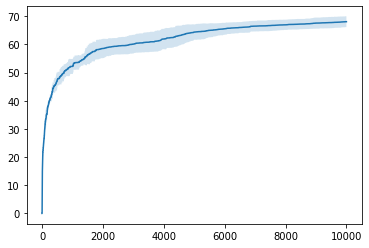

In [ ]:
T=10000
NRUNS = 2
rep = LinearRepresentation(env.features)

regrets = np.zeros((NRUNS,T))
for r in range(NRUNS):
    algo = LinUCB(
        env, representation=rep, reg_val=1, 
        noise_std=NOISE, 
        features_bound=np.linalg.norm(env.features,2, axis=-1).max(), 
        param_bound=np.linalg.norm(env.param,2)
    )
    output = algo.run(T)
    regrets[r] = output['regret']

mr = np.mean(regrets, axis=0)
vr = np.std(regrets, axis=0) / np.sqrt(NRUNS)
plt.plot(np.arange(T), mr)
plt.fill_between(np.arange(T), mr - 2*vr, mr + 2*vr, alpha=0.2)

We can construct equivalent representations with the *same size*. 

We already provide the code for building such representations.

In [ ]:
rep_list = []
param_list = []
for i in range(1, dim):
    fi, pi = derank_hls(features=features, param=param, newrank=i, transform=True, normalize=True, seed=np.random.randint(1, 1234144,1))
    rep_list.append(LinearRepresentation(fi))
    param_list.append(pi)
rep_list.append(LinearRepresentation(features))
param_list.append(param)

for i in range(len(rep_list)):
    print()
    print(f"feature norm({i}): {np.linalg.norm(rep_list[i].features,2,axis=-1).max()}")
    print(f"param norm({i}): {np.linalg.norm(param_list[i],2)}")
    assert np.allclose(rep_list[i].features @ param_list[i], features @ param) #check that they are all equivalent
print()


feature norm(0): 6.952250387125886
param norm(0): 1.0

feature norm(1): 6.952250387125886
param norm(1): 1.0

feature norm(2): 6.952250387125887
param norm(2): 1.0

feature norm(3): 6.9522503871258845
param norm(3): 1.0

feature norm(4): 6.952250387125887
param norm(4): 1.0

feature norm(5): 6.952250387125889
param norm(5): 1.0

feature norm(6): 6.952250387125886
param norm(6): 1.0

feature norm(7): 6.952250387125887
param norm(7): 1.0

feature norm(8): 6.952250387125886
param norm(8): 1.0

feature norm(9): 7.119707353985564
param norm(9): 1.0



Let's run LinUCB with each representation

In [ ]:
T=20000
NRUNS = 2

results = {}
for nr, rep in enumerate(rep_list):
    regrets = np.zeros((NRUNS,T))
    for r in range(NRUNS):
        algo = LinUCB(env, representation=rep, reg_val=1, noise_std=NOISE, 
                      features_bound=np.linalg.norm(rep.features,2, axis=-1).max(),
                      param_bound=np.linalg.norm(param_list[nr],2)
                      )
        output = algo.run(T)
        regrets[r] = output['regret']

    mr = np.mean(regrets, axis=0)
    vr = np.std(regrets, axis=0) / np.sqrt(NRUNS)
    results[f'LinUCB-rep_{nr}'] = {'regret': mr, "std": vr}

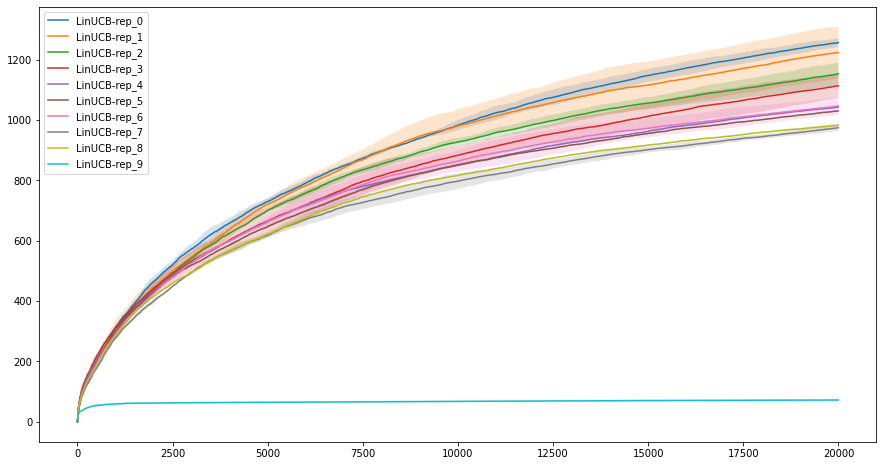

In [ ]:
plt.figure(figsize=(15,8))
for k,v in results.items():
    plt.plot(np.arange(T), v['regret'], label=k)
    plt.fill_between(np.arange(T), v['regret'] - 2*v['std'], v['regret'] + 2*v['std'], alpha=0.2)
plt.legend()

If everything is implemented correctly, there is a representation with a much better regret. 

**Q1**: Why? What is the property of such a representation?

See [Leveraging Good Representations in Linear Contextual Bandits](https://arxiv.org/abs/2104.03781) for the answer.

As expected, we can see that representation 9 has a much better regret than the others. Moreover, according the the article *Leveraging Good Representations in Linear Contextual Bandits*, for the LinUBC algorithm that we implemented, in order to have a constant regret, it is necessary and sufficient for the representation to satisfy the HLS condition.  

In our case, the different representations are defined using a deranking of a representation. In fact, the ith representation removes i dimensions of a representation that satisfies HLS. Thus, the 9th representation is the only one to satisfy the HLS condition, so it has the best regret of all.

hhen the HLS condition holds, we could say that, with high probabilty, the algorithm will pull the optimal arm with large minimum gap.Therefor, the algorithm collects sufficient information about $\theta_{\phi^\star}$. This induces at most a constant regret. 


# Step 2: representation selection

Now that we have seen that not all the representations are equal, we want to design an algorithm able to leverage the most efficient representation when provided with a set of **realizable** representations.


This algorithm exists and is called LEADER. Implement the LEADER algorithm as reported in the paper ["Leveraging Good Representations in Linear Contextual Bandits"](https://arxiv.org/abs/2104.03781).

In [ ]:
class LEADER:
  
    def __init__(self, 
                 env, representations, reg_val, noise_std,
                 features_bounds,
                 param_bounds, delta=0.01, random_state=0
        ):
        self.env = env
        self.reps = representations #list of representations
        self.reg_val = reg_val
        self.noise_std = noise_std
        self.features_bound = features_bounds #list of feature bounds
        self.param_bound=param_bounds #list of parameter bounds
        self.delta = delta
        self.random_state = random_state
        self.rng = np.random.RandomState(random_state)

    def run(self, horizon):
        instant_reward = np.zeros(horizon)
        best_reward = np.zeros(horizon)
        M = len(self.reps)
        
        inv_A = []
        b_vec = []
        A_logdet = []
        theta = []
        for i in range(M):
            dim = self.reps[i].features_dim()
            
            # Initialize required variables
            #--------------------------------------------
            # TODO
            #--------------------------------------------
            inv_A.append(1/ self.reg_val * np.eye(dim))
            b_vec.append(np.zeros(dim))
            A_logdet.append(-np.log(np.linalg.det(inv_A[i])))
            theta.append(np.zeros(dim))
        for t in range(horizon):
            context = env.sample_context()
            avail_actions = env.get_available_actions()

            # Implement the action selection strategy
            #--------------------------------------------
            # TODO
            # action =
            #--------------------------------------------
            all_UCB = np.zeros((M,len(avail_actions)))

            for i in range(M):
              dim = self.reps[i].features_dim()

              beta_t = self.noise_std*np.sqrt(A_logdet[i] - dim*np.log(self.reg_val) - 2 * np.log(self.delta)) + np.sqrt(self.reg_val)*self.param_bound[i]
    
              for j in range(len(avail_actions)):
                phi_t = self.reps[i].get_features(context, avail_actions[j])
                all_UCB[i,j] = np.dot(phi_t, theta[i]) + beta_t * np.sqrt(np.dot(phi_t, np.dot(inv_A[i], phi_t)))

            action = avail_actions[np.argmax(np.min(all_UCB,axis=0))]    
            #execute action
            reward = env.step(action)

            # update
            for j in range(M):
                v = self.reps[j].get_features(context, action)
                # update internal model
                #--------------------------------------------
                # TODO
                #--------------------------------------------
                inv_A[j] -= (inv_A[j]@np.outer(v,v)@inv_A[j])/(1 + v.T @ inv_A[j] @ v)
                b_vec[j] += reward * v
                A_logdet[j] = -np.log(np.linalg.det(inv_A[j]))
                theta[j] = inv_A[j] @ b_vec[j]
            
            # regret computation
            instant_reward[t] = self.env.expected_reward(action)
            best_reward[t] = self.env.best_reward()
        
        
        # define the regret
        #--------------------------------------------
        regret = [np.sum(best_reward[:t] - instant_reward[:t]) for t in range(horizon)]
        #--------------------------------------------
        return {"regret": regret}

In [ ]:
regrets = np.zeros((NRUNS,T))
M = len(rep_list)
for r in range(NRUNS):
    algo = LEADER(env, representations=rep_list, reg_val=1, noise_std=NOISE, 
                  features_bounds=[np.linalg.norm(rep_list[j].features,2, axis=-1).max() for j in range(M)], 
                  param_bounds=[np.linalg.norm(param_list[j],2) for j in range(M)]
    )
    output = algo.run(T)
    regrets[r] = output['regret']

mr = np.mean(regrets, axis=0)
vr = np.std(regrets, axis=0) / np.sqrt(NRUNS)
results['LEADER'] = {'regret': mr, 'std': vr}

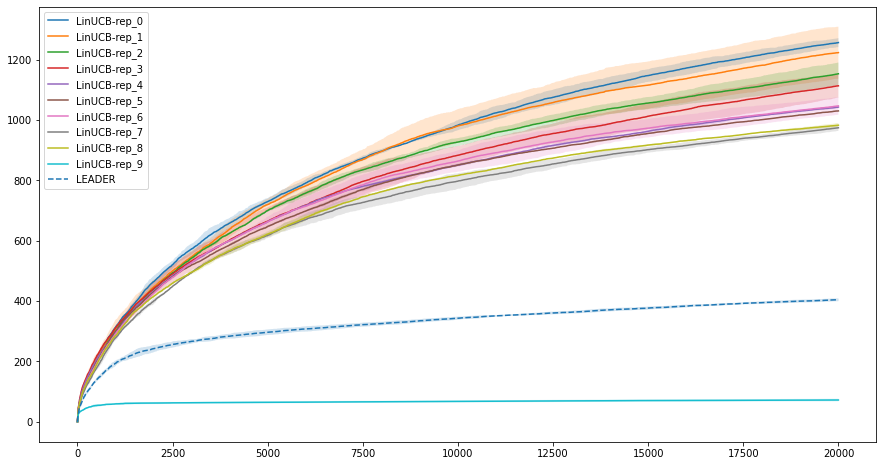

In [ ]:
plt.figure(figsize=(15,8))
for k,v in results.items():
    if k == 'LEADER':
      plt.plot(np.arange(T), v['regret'], '--', label=k)
    else:
      plt.plot(np.arange(T), v['regret'], label=k)
    plt.fill_between(np.arange(T), v['regret'] - 2*v['std'], v['regret'] + 2*v['std'], alpha=0.2)
plt.legend()

If correctly implemented, LEADER should have the second best performance

**Q2**: so far we have considered only *realizable* representations, i.e., $\forall i, \exists \theta \in \mathbb{R}^{d_i}$ such that $r(s,a) = \phi_i(s,a)^\top \theta$, for all $s,a$. Now suppose that this property holds only for a single representation $i^\star$, while for all $i\neq i^\star$ we have $\forall \theta \in \mathbb{R}^{d_i} \exists s,a$ such that $r(s,a) \neq \phi_i(s,a)^\top \theta$. Do you think the LEADER algorithm would still work (i.e., achieve sub-linear regret) for this setting? Why?

**Answer :**

If we have, for $i\neq i^\star$, that $\forall \theta \in \mathbb{R}^{d_i} \exists s,a$ such that $r(s,a) \neq \phi_i(s,a)^\top \theta$ then we cannot compute the upper bound of the rewards as we do in LEADER, as the optimistic estimate of the reward is not true. 
If one can still compute this upper bound, maybe the LEADER algorithm can still work, but in the general case, it will not achieve a sub-linear regret. 